In [1]:
 !pip install gym-super-mario-bros

     |████████████████████████████████| 198 kB 11.9 MB/s 
     |████████████████████████████████| 76 kB 5.1 MB/s 
  Created wheel for nes-py: filename=nes_py-8.1.8-cp37-cp37m-linux_x86_64.whl size=439057 sha256=5f7e531de55a1e02f810cf3f40fb93e083267855ce69a07359b9b7b9010d330b
  Stored in directory: /root/.cache/pip/wheels/f2/05/1f/608f15ab43187096eb5f3087506419c2d9772e97000f3ba025
Successfully built nes-py


## Importing Libraries

In [8]:
import tensorflow as tf
import random 
import gym
import numpy as np
from collections import deque
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
import gym_super_mario_bros
from gym_super_mario_bros.actions import RIGHT_ONLY
from nes_py.wrappers import JoypadSpace
import IPython.display as display

from keras.models import save_model
from keras.models import load_model

import time

import matplotlib.pyplot as plt
%matplotlib inline
import random


In [3]:
env = gym_super_mario_bros.make('SuperMarioBros-v1')
env = JoypadSpace(env, RIGHT_ONLY)

## Deep Q-Network Model

In [4]:
class DQNAgent:
  def __init__(self, state_size, action_size, epislon=1):
    #create variables for our agent
     self.state_space = state_size
     self.action_space = action_size
     self.memory = deque(maxlen=5000)
     self.gamma = 0.8
     self.chosenAction = 0

     #Exploration vs Explotation
     self.epislon = epislon
     self.max_epislon = 1
     self.min_epislon = 0.01
     self.epislon_decay = 0.0001

     #Building Neural Networks for Agent
     self.main_network = self.build_network()
     self.target_network = self.build_network()
     self.update_target_network()

  def build_network(self):
    model = Sequential()
    model.add(Conv2D(64, (4,4), strides = 4, padding='same', input_shape=self.state_space))
    model.add(Activation('relu'))

    model.add(Conv2D(64, (4,4), strides = 4, padding='same', input_shape=self.state_space))
    model.add(Activation('relu'))

    model.add(Conv2D(64, (3,3), strides = 4, padding='same', input_shape=self.state_space))
    model.add(Activation('relu'))
    model.add(Flatten())
    
    model.add(Dense(512, activation='relu'))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(self.action_space,activation='linear'))

    model.compile(loss= 'mse',optimizer=Adam())

    return model

  def update_target_network(self):
    self.target_network.set_weights(self.main_network.get_weights())

  def act(self,state,onGround=79):
    if onGround < 83:
      print("On-Ground")
      if random.uniform(0,1) < self.epislon:
        self.chosenAction = np.random.randint(self.action_space)
        return self.chosenAction
      Q_value = self.main_network.predict(state)
      self.chosenAction = np.argmax(Q_value[0])
      return self.chosenAction
    else:
      print("Not on Ground")
      return self.chosenAction
    
  def get_pred_act(self,state):
    Q_value = self.main_network.predict(state)
    return np.argmax(Q_value[0])

  def update_epislon(self, episode):
    self.epislon = self.min_epislon + (self.max_epislon - self.min_epislon) * np.exp(-self.epislon_decay * episode)
  
  def train(self, batch_size):
    #minibatch memory
    minibatch = random.sample(self.memory, batch_size)

    #Get values from batch so we can find q-value
    for state, action, reward, next_state, done in minibatch:
      target = self.main_network.predict(state)

      if done:
        target[0][action] = reward
      else:
        target[0][action] = (reward + self.gamma * np.amax(self.target_network.predict(next_state)))

      self.main_network.fit(state, target, epochs=1, verbose=0)

  def store_transition(self, state, action, reward, next_state, done):
    self.memory.append((state,action,reward,next_state,done))

  def load_model(self,name):
    self.main_network = load_model(name)
    self.target_network = load_model(name)
  
  def save_model(self,name):
    save_model(self.main_network, name)

## Preprocessing

In [5]:
action_space = env.action_space.n
state_space = (80, 88, 1)

from PIL import Image

def preprocess_state(state):
  image = Image.fromarray(state)
  image = image.resize((88,80))
  image = image.convert('L')
  image = np.array(image)

  return image
#env.observation_space

In [6]:
num_episodes = 5
num_timesteps = 2000
batch_size = 64
DEBUG_LENGTH = 300

In [7]:
dqn = DQNAgent(state_space,action_space)

## Training

In [ ]:
print("STARTING Training\n")

stuck_buffer = deque(maxlen=DEBUG_LENGTH)

for i in range(num_episodes):
  Return = 0
  done = False
  time_step = 0
  onGround = 79
    
#   random_time_steps = []
#   if (i+1)%2==0:
#     random_time_steps = random.sample(range(num_timesteps),num_timesteps//2)
  state = preprocess_state(env.reset())
  state = state.reshape(-1,80,88,1)
  img = plt.imshow(env.render(mode='rgb_array')) # only call this once. # For Colab
  for t in range(num_timesteps):
    img.set_data(env.render(mode='rgb_array')) # just update the data # For Colab
    display.clear_output(wait=True)
    display.display(plt.gcf())
    # env.render() # For Jupyter

    time_step += 1

    if t>1 and stuck_buffer.count(stuck_buffer[-1])>DEBUG_LENGTH-50:
      action = dqn.act(state,onGround=79)
    else:
      action = dqn.act(state,onGround)
    
    next_state, reward, done, info = env.step(action)

    print("x_pos:",info['x_pos']," y_pos:",info['y_pos'])
    onGround = info['y_pos']
    stuck_buffer.append(info['x_pos'])

    next_state = preprocess_state(next_state)
    next_state = next_state.reshape(-1,80,88,1)

    dqn.store_transition(state, action, reward, next_state, done)
    state = next_state

    Return += reward
    print("Episode is: {}\nTotal Time Step: {}\nCurrent Reward: {}\nEpsilon: {}".format(str(i),str(time_step),str(Return),str(dqn.epislon)))

    
    if len(dqn.memory) > batch_size and i>0:
      print("\n---------DQN Training Starts--------\n")
      dqn.train(batch_size)
      print("---------DQN Training Ends-----------\n")
      dqn.save_model('mario-RL.h5')
      #time.sleep(1)

    display.clear_output(wait=True)
    if done:
      break

  
  dqn.update_epislon(i)
  display.clear_output(wait=True)
  dqn.update_target_network()

env.close()  

Not on Ground
x_pos: 49  y_pos: 134
Episode is: 1
Total Time Step: 17
Current Reward: 9
Epsilon: 1.0

---------DQN Training Starts--------

---------DQN Training Ends-----------



In [ ]:
dqn.save_model('mario-RL.h5')

## Visualization of Trained Model

In [14]:
dqn = DQNAgent(state_space,action_space)

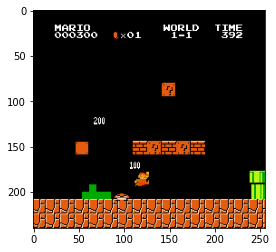

In [ ]:
# Visualizing Trained Model
dqn.load_model('mario-RL.h5')
while True:
  done = False
  state = preprocess_state(env.reset())
  state = state.reshape(-1, 80, 88, 1)
  total_reward = 0
  
  img = plt.imshow(env.render(mode='rgb_array'))
  while not done:
    img.set_data(env.render(mode='rgb_array')) # just update the data # For Colab
    display.clear_output(wait=True)
    display.display(plt.gcf())
    #env.render()
    
    action = dqn.get_pred_act(state)
    next_state, reward, done, info = env.step(action)

    next_state = preprocess_state(next_state)
    next_state = next_state.reshape(-1, 80, 88, 1)
    state = next_state

env.close()